In [33]:
import os
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [34]:
dir_train='/kaggle/input/100-bird-species/train/'
dir_test='/kaggle/input/100-bird-species/test/'
dir_valid='/kaggle/input/100-bird-species/valid/'
df=pd.read_csv('/kaggle/input/100-bird-species/birds.csv') #データセット全体
df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [35]:
len(df['class id'].unique()) #クラス数

525

In [36]:
df['data set'].value_counts() #各データセットの数

data set
train    84635
test      2625
valid     2625
Name: count, dtype: int64

In [37]:
df["labels"].value_counts() #各ラベルの数

labels
RUFOUS TREPE               273
HOUSE FINCH                258
D-ARNAUDS BARBET           243
OVENBIRD                   243
ASIAN GREEN BEE EATER      230
                          ... 
NORTHERN RED BISHOP        140
SNOWY PLOVER               140
PATAGONIAN SIERRA FINCH    140
EURASIAN GOLDEN ORIOLE     140
RED TAILED THRUSH          140
Name: count, Length: 525, dtype: int64

In [38]:
transform=T.Compose([
    T.Resize((128,128)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor()
])

trans_valid=T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

train_ds=torchvision.datasets.ImageFolder(root=dir_train,transform=transform)
valid_ds=torchvision.datasets.ImageFolder(root=dir_valid,transform=trans_valid)

In [39]:
len(train_ds.classes)

525

In [40]:
train_dl=DataLoader(train_ds, batch_size=64, num_workers=2 ,shuffle=True)
valid_dl=DataLoader(valid_ds, batch_size=64, num_workers=2 ,shuffle=True)

In [41]:
def show_images(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.imshow(make_grid(images[:32],nrow=8).permute(1,2,0))
        break

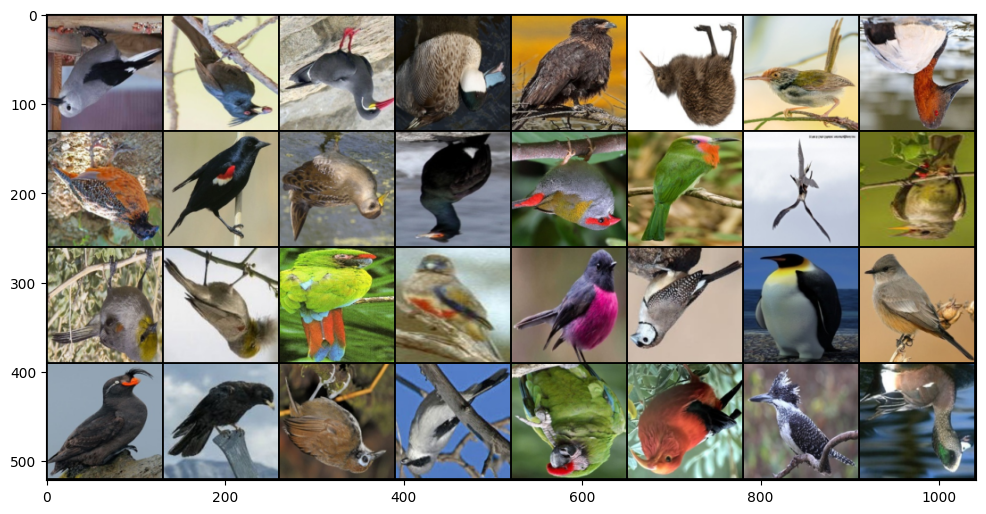

In [42]:
show_images(train_dl)

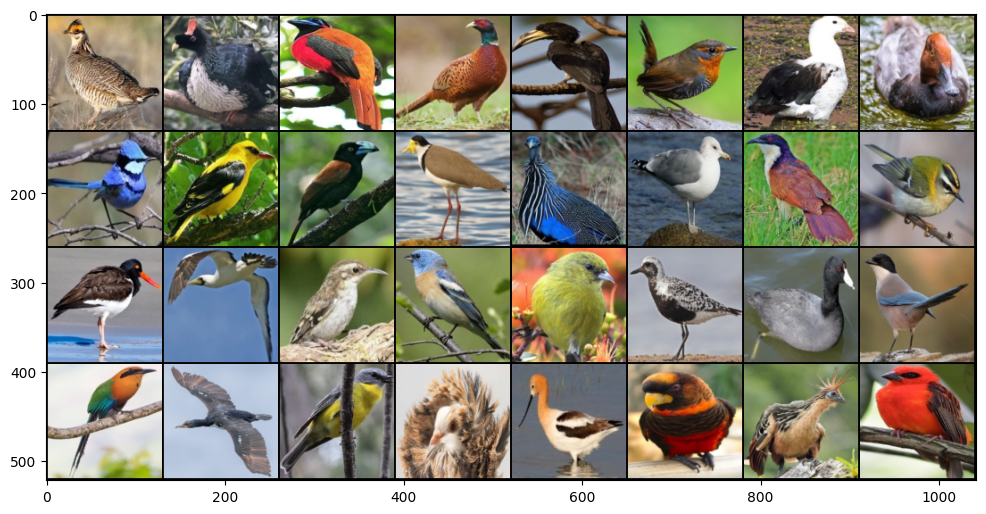

In [43]:
show_images(valid_dl)

In [44]:
def train_model(model, optimizer, criterion, epochs):
    history={'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
    for epoch in range(epochs):
        train_loss = 0.
        train_acc = 0.
        valid_loss = 0.
        valid_acc = 0.
        train_total = 0
        valid_total = 0
        
        #Training
        for images,labels in train_dl:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            _, indices = torch.max(pred.data, axis=1) 
            train_acc += (indices==labels).sum().item() 
            train_total += labels.size(0) 
            
        history["loss"].append(train_loss)  
        history["acc"].append(train_acc/train_total) 
        
        #Validation
        with torch.no_grad():
            for images,labels in valid_dl:
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)
                loss = criterion(pred, labels)
                valid_loss += loss.item()
                values, indices = torch.max(pred.data, axis=1)  
                valid_acc += (indices==labels).sum().item()
                valid_total += labels.size(0) 
                
        history["val_loss"].append(valid_loss)  
        history["val_acc"].append(valid_acc/valid_total)
        
        if (epoch+1)%5==0:
            print('Epoch:',epoch+1)
            print('train_loss:',history['loss'][-1])
            print('train_accuracy:',history['acc'][-1])
            print('valid_loss:',history['val_loss'][-1])
            print('valid_accuracy:',history['val_acc'][-1])
            
    return history

In [45]:
model=models.vgg16(pretrained=True)
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
epochs=10
train_steps = len(train_dl)
valid_steps = len(valid_dl)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()
metrics={'loss':[],'val_loss':[],'val_acc':[]}
for epoch in range(epochs):
    train_loss=[]
    valid_loss=[]
    model.train()
    for batch in train_dl:
        optimizer.zero_grad()
        images,labels=batch
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.item())
        if len(train_loss)%100==0:
            print('Epoch:',epoch+1)
            print('train_loss:',train_loss[-1])
            
    model.eval()
    num_correct=0
    num_sample=0
    for batch in valid_dl:
        optimizer.zero_grad()
        images,labels=batch
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = criterion(pred, labels)
        valid_loss.append(loss.data.item())
        values, indices = torch.max(pred.data, axis=1)  
        num_correct+=(indices==labels).sum().item()
        num_sample+=labels.size(0) 
        if len(valid_loss)%20==0:
            print('Epoch:',epoch+1)
            print('valid_loss:',valid_loss[-1])
    accuracy=num_correct / num_sample
    train_loss_mean=torch.mean(torch.Tensor(train_loss)).item()
    valid_loss_mean=torch.mean(torch.Tensor(valid_loss)).item()
    metrics["loss"].append(train_loss_mean)
    metrics["val_loss"].append(valid_loss_mean)
    metrics["val_acc"].append(accuracy)
    print('training_loss:',train_loss_mean, 'validation_loss:', valid_loss_mean, 'accuracy:',accuracy)

Epoch: 1
train_loss: 6.449741840362549
Epoch: 1
train_loss: 6.1775593757629395
Epoch: 1
train_loss: 5.838722229003906
Epoch: 1
train_loss: 5.673666954040527
Epoch: 1
train_loss: 5.666860580444336
Epoch: 1
train_loss: 4.984480857849121
Epoch: 1
train_loss: 4.529587268829346
Epoch: 1
train_loss: 4.037281036376953
Epoch: 1
train_loss: 3.2740068435668945
Epoch: 1
train_loss: 3.497607469558716
Epoch: 1
train_loss: 2.9002275466918945
Epoch: 1
train_loss: 2.9944400787353516
Epoch: 1
train_loss: 2.651881456375122
Epoch: 1
valid_loss: 2.417409896850586
Epoch: 1
valid_loss: 2.064427614212036
training_loss: 4.679341793060303 validation_loss: 1.9379172325134277 accuracy: 0.5245714285714286
Epoch: 2
train_loss: 2.3626365661621094
Epoch: 2
train_loss: 2.405545473098755
Epoch: 2
train_loss: 2.4997544288635254
Epoch: 2
train_loss: 1.4817663431167603
Epoch: 2
train_loss: 1.8917771577835083
Epoch: 2
train_loss: 1.4405454397201538
Epoch: 2
train_loss: 1.3323482275009155
Epoch: 2
train_loss: 2.05924201011

<Axes: >

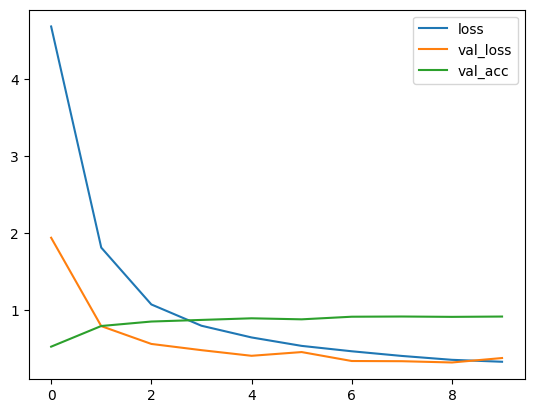

In [47]:
pd.DataFrame(metrics).plot()